In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
resource_path = "/content/drive/MyDrive/Ventilator-Pressure-Prediction/"
local_resource_path = "../models/"
data_path = "../input/"
running_enviroment = "local"

%matplotlib inline

In [15]:
!cat /proc/cpuinfo

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [13]:
if running_enviroment == "colab":
    data_df = pd.read_csv(resource_path + 'train.csv')
else:
    data_df = pd.read_csv(data_path + 'train.csv')

In [14]:
data_df.shape

(6036000, 8)

In [15]:
# To convert string data into numeric which was numeric in nature 
data_df = data_df.apply(pd.to_numeric, errors='ignore')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [16]:
data_df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


<ipython-input-17-0b46c19d2484>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data_df.hist(ax = ax)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020BCFF8F040>,
      dtype=object)

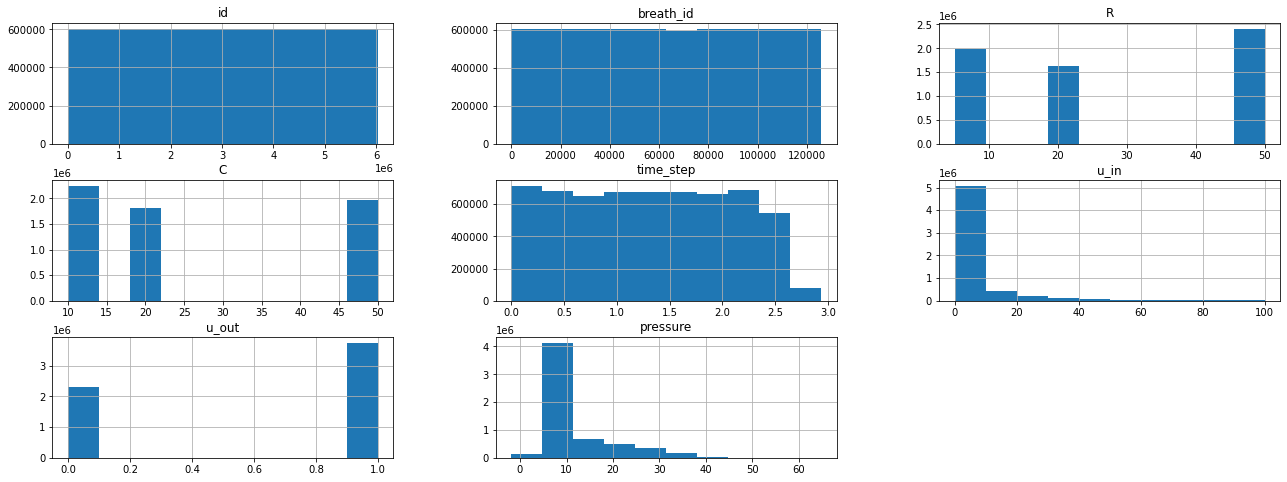

In [17]:
figure = plt.figure(figsize=(22, 8))
ax = figure.gca()
data_df.hist(ax = ax)

In [18]:
# Get the categorical columns for transforming
set(data_df.columns) - set(data_df._get_numeric_data().columns)

set()

C:\Users\Hemant\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Hemant\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Hemant\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

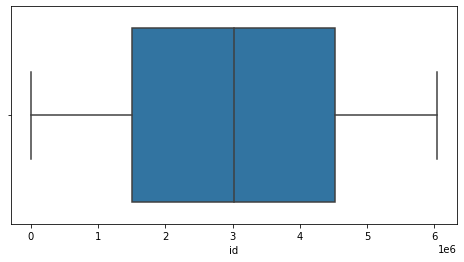

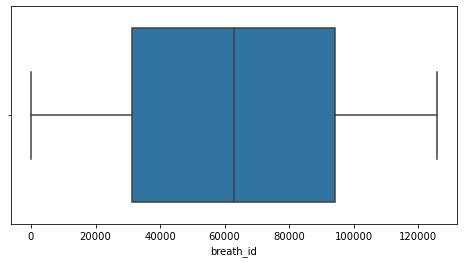

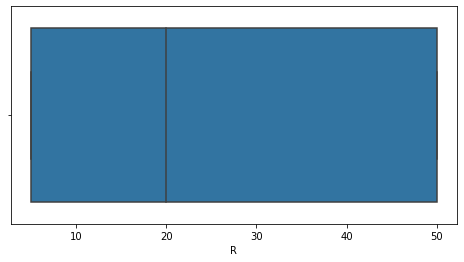

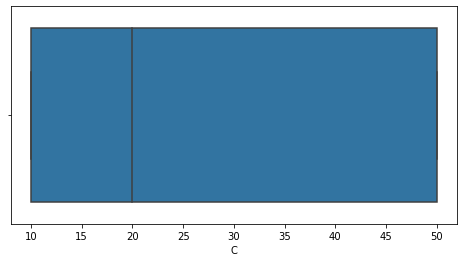

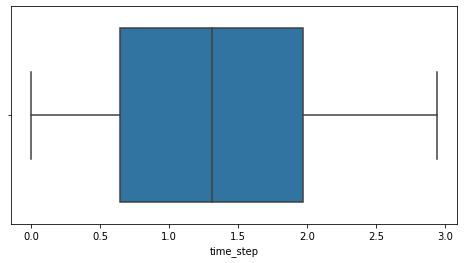

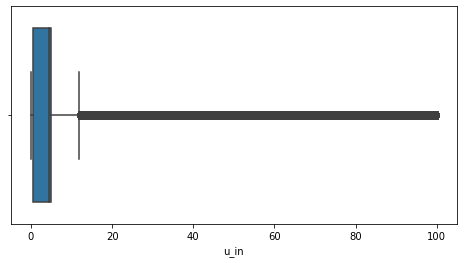

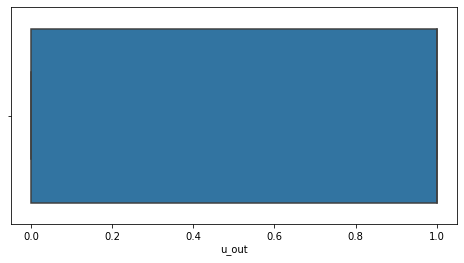

In [19]:
train_columns = list(data_df.columns)
train_columns.remove("pressure")

for column in train_columns:
  plt.figure(figsize=(8,4))
  sns.boxplot(column, data=data_df)

In [20]:
# Treat outlier
from sklearn import impute

def treat_outlier_and_null(columns):
  for column_name in columns:
    column = data_df[column_name]
    iqr = np.quantile(column, 0.75) - np.quantile(column, 0.25)
    upper_bound = np.quantile(column, 0.75) + 1.25*iqr
    lower_bound = np.quantile(column, 0.25) - 1.25*iqr
    is_outlier_found = column[(column>upper_bound) | (column<lower_bound)]

    if list(is_outlier_found):
      column[(column>upper_bound) | (column<lower_bound)] = np.nan

    # Method2: static_imputation
    if data_df[column_name].dtypes == 'O':
      data_df[column_name] = data_df[column_name].fillna(data_df[column_name].mode().iloc[0])
    else:
      data_df[column_name] = data_df[column_name].fillna(data_df[column_name].median())

# Check the null values in the data
print(data_df.isnull().sum())
treat_outlier_and_null(train_columns)
print(data_df.isnull().sum())

# Method1: Fill in the null values with KNN
# knn_imputer = impute.KNNImputer(n_neighbors=5)
# filled_data_df = knn_imputer.fit_transform(data_df.drop(["id", "breath_id", "time_step"], axis=1))
# data_df.loc[:, ['R', 'C', 'u_in', 'u_out',  'pressure']] = filled_data_df

data_df.head()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64


<ipython-input-20-3823841978f3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[(column>upper_bound) | (column<lower_bound)] = np.nan


id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,3.587056,0,5.907794
2,3,1,20,50,0.067514,3.587056,0,7.876254
3,4,1,20,50,0.101542,3.587056,0,11.742872
4,5,1,20,50,0.135756,3.587056,0,12.234987


In [21]:
# Adding some features based on the provided data
def generate_features(df):

    # create an aggregate dictionary
    aggs = {}
    aggs['C'] = ['max', 'min', 'mean']
    aggs['R'] = ['max', 'min', 'mean']
    aggs['u_in'] = ['max', 'min', 'mean', 'std', 'var']

    # we group by breath_id and calculate the aggregates
    agg_df = df.groupby('breath_id').agg(aggs)
    agg_df = agg_df.reset_index()
    new_agg_columns = []

    for agg_columns in list(agg_df.columns):
        column_name = agg_columns[0] + "_" + agg_columns[1]
        new_agg_columns.append(column_name.strip("_"))

    agg_df.columns = new_agg_columns
    return agg_df

agg_df = generate_features(data_df)
data_df = pd.merge(data_df, agg_df, how='left', on = 'breath_id')

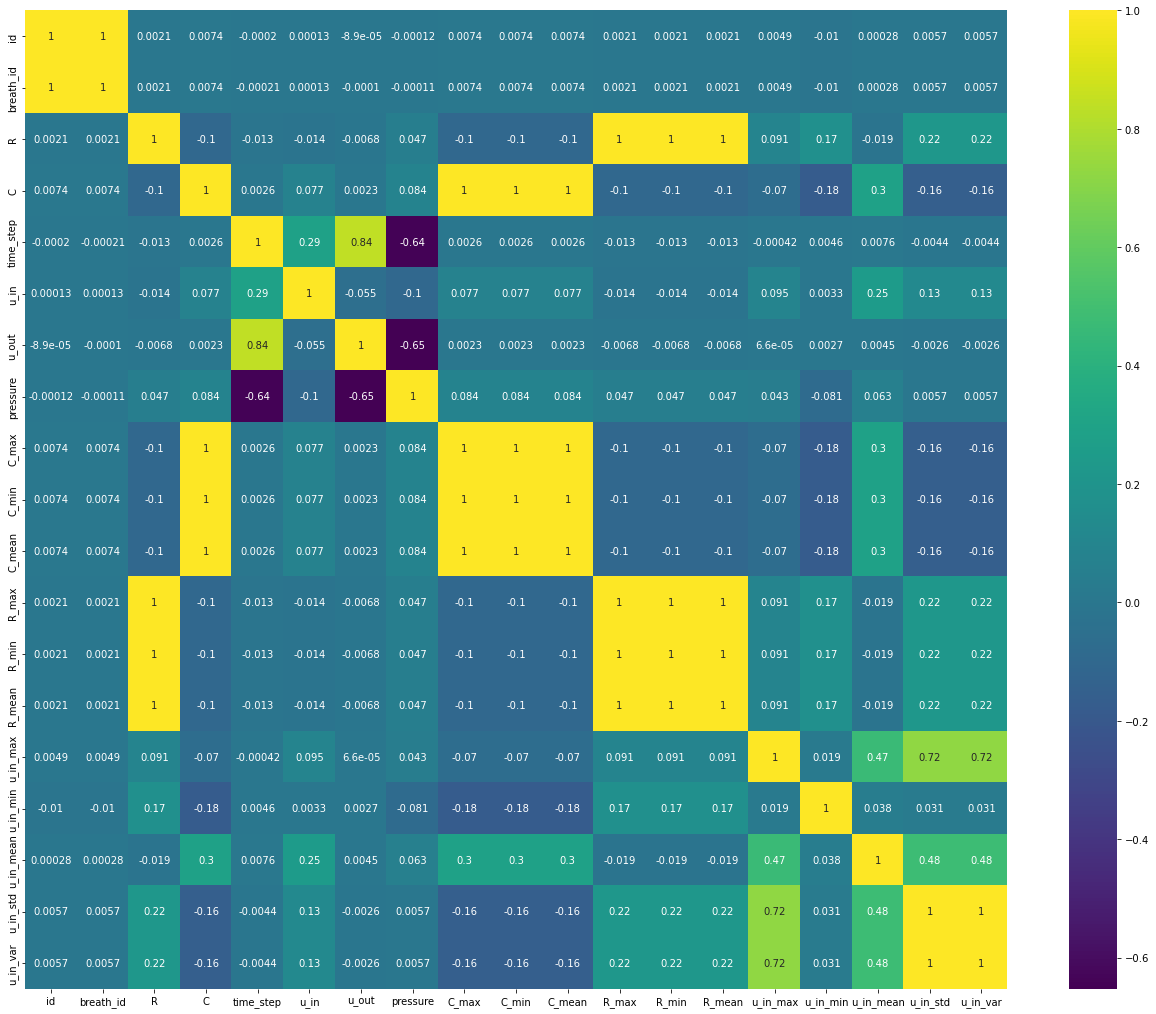

In [22]:
plt.figure(figsize=(22, 18))
sns.heatmap(data_df.corr(method='spearman'), annot=True, cmap='viridis')

In [23]:
from sklearn.feature_selection import VarianceThreshold

# Perform feature selection
def feature_selection(dataset, corr_threshold, var_threshold):
    var_thresh = VarianceThreshold(threshold=var_threshold)
    transformed_data = var_thresh.fit_transform(dataset)
    var_columns = var_thresh.variances_ > var_threshold
    var_removed_columns = [not column for column in var_columns]
    removed_columns = set(dataset.iloc[:, var_removed_columns].columns)
    print(f"variance removed column: {removed_columns}")

    corr_matrix = dataset.corr(method='spearman')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > corr_threshold:
                colname = corr_matrix.columns[i]
                removed_columns.add(colname)
    print(f"variance and correlation removed column: {removed_columns}")
    return removed_columns

removed_columns = feature_selection(data_df.drop(["pressure"], axis=1), 0.85, 0.1)
removed_columns.add("id")
data_df.drop(list(removed_columns), axis=1, inplace=True)
data_df.head()

variance removed column: {'u_in_min'}
variance and correlation removed column: {'C_min', 'R_max', 'breath_id', 'R_min', 'C_mean', 'C_max', 'R_mean', 'u_in_min', 'u_in_var'}


,R,C,time_step,u_in,u_out,pressure,u_in_max,u_in_mean,u_in_std
0,20,50,0.000000,0.083334,0,5.837492,4.987079,3.152422,1.763825
1,20,50,0.033652,3.587056,0,5.907794,4.987079,3.152422,1.763825
2,20,50,0.067514,3.587056,0,7.876254,4.987079,3.152422,1.763825
3,20,50,0.101542,3.587056,0,11.742872,4.987079,3.152422,1.763825
4,20,50,0.135756,3.587056,0,12.234987,4.987079,3.152422,1.763825


In [24]:
from sklearn.model_selection import train_test_split

data_df = data_df.sample(frac=0.01)
print(data_df.shape)

X = data_df.drop(["pressure"], axis=1)
y = data_df["pressure"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

(60360, 9)


In [25]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

if running_enviroment == "colab":
    joblib.dump(scaler, resource_path + 'ventilator-scaler-lower.pkl')
else:
    joblib.dump(scaler, local_resource_path + 'ventilator-scaler-lower.pkl')

In [ ]:
#1st model: RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

regressor = RandomForestRegressor(n_jobs=-1)
param_grid = {
 "n_estimators": [120, 300, 500, 800, 1200],
 "max_depth": [5, 8, 15, 25, 30, None],
 "min_samples_split": [1.0, 2, 5, 10, 15, 100],
 "min_samples_leaf": [1, 2, 5, 10],
 "max_features" : ["log2", "sqrt", None]
}

model = model_selection.RandomizedSearchCV(
 estimator=regressor,
 param_distributions=param_grid,
 n_iter=2,
 scoring="neg_mean_absolute_error",
 verbose=100,
 n_jobs=1,
 cv=4
)

model.fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test) 

if running_enviroment == "colab":
    joblib.dump(model, resource_path + 'random_forest_model1.joblib')
else:
    joblib.dump(model, local_resource_path + 'random_forest_model1.joblib')

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

In [17]:
#1st model: RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

regressor = RandomForestRegressor(n_jobs=-1)
param_grid = {
 "n_estimators": [120, 300, 500, 800, 1200],
 "max_depth": [5, 8, 15, 25, 30, None],
 "min_samples_split": [1.0, 2, 5, 10, 15, 100],
 "min_samples_leaf": [1, 2, 5, 10],
 "max_features" : ["log2", "sqrt", None]
}

model = model_selection.RandomizedSearchCV(
 estimator=regressor,
 param_distributions=param_grid,
 n_iter=2,
 scoring="neg_mean_absolute_error",
 verbose=100,
 n_jobs=1,
 cv=4
)

model.fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test) 

if running_enviroment == "colab":
    joblib.dump(model, resource_path + 'random_forest_model2.joblib')
else:
    joblib.dump(model, local_resource_path + 'random_forest_model2.joblib')
    
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 1/4; 1/2] START max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300
[CV 1/4; 1/2] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 8.6min
[CV 2/4; 1/2] START max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300
[CV 2/4; 1/2] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 8.4min
[CV 3/4; 1/2] START max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300
[CV 3/4; 1/2] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 8.5min
[CV 4/4; 1/2] START max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300
[CV 4/4; 1/2] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimato

In [18]:
#1st model: RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

regressor = RandomForestRegressor(n_jobs=-1)
param_grid = {
 "n_estimators": [120, 300, 500, 800, 1200],
 "max_depth": [5, 8, 15, 25, 30, None],
 "min_samples_split": [1.0, 2, 5, 10, 15, 100],
 "min_samples_leaf": [1, 2, 5, 10],
 "max_features" : ["log2", "sqrt", None]
}

model = model_selection.RandomizedSearchCV(
 estimator=regressor,
 param_distributions=param_grid,
 n_iter=2,
 scoring="neg_mean_absolute_error",
 verbose=100,
 n_jobs=1,
 cv=4
)

model.fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test) 

if running_enviroment == "colab":
    joblib.dump(model, resource_path + 'random_forest_model3.joblib')
else:
    joblib.dump(model, local_resource_path + 'random_forest_model3.joblib')
    
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 1/4; 1/2] START max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1200
[CV 1/4; 1/2] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1200; total time=25.7min
[CV 2/4; 1/2] START max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1200
[CV 2/4; 1/2] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1200; total time=25.4min
[CV 3/4; 1/2] START max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1200
[CV 3/4; 1/2] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1200; total time=25.4min
[CV 4/4; 1/2] START max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1200
[CV 4/4; 1/2] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_sample

In [19]:
#1st model: RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

regressor = RandomForestRegressor(n_jobs=-1)
param_grid = {
 "n_estimators": [120, 300, 500, 800, 1200],
 "max_depth": [5, 8, 15, 25, 30, None],
 "min_samples_split": [1.0, 2, 5, 10, 15, 100],
 "min_samples_leaf": [1, 2, 5, 10],
 "max_features" : ["log2", "sqrt", None]
}

model = model_selection.RandomizedSearchCV(
 estimator=regressor,
 param_distributions=param_grid,
 n_iter=2,
 scoring="neg_mean_absolute_error",
 verbose=100,
 n_jobs=1,
 cv=4
)

model.fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test) 

if running_enviroment == "colab":
    joblib.dump(model, resource_path + 'random_forest_model4.joblib')
else:
    joblib.dump(model, local_resource_path + 'random_forest_model4.joblib')
    
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 1/4; 1/2] START max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800
[CV 1/4; 1/2] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=15.8min
[CV 2/4; 1/2] START max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800
[CV 2/4; 1/2] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=15.8min
[CV 3/4; 1/2] START max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800
[CV 3/4; 1/2] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=15.8min
[CV 4/4; 1/2] START max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800
[CV 4/4; 1/2] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; 

In [26]:
#2nd model: SVM
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100], 
            "gamma": ["scale", "auto"]}
svm_model = model_selection.RandomizedSearchCV(SVR(), parameters, verbose=100, n_iter=2, cv=4)
svm_model.fit(scaled_X_train, y_train)
y_pred = svm_model.predict(scaled_X_test)

if running_enviroment == "colab":
    joblib.dump(svm_model, resource_path + 'svm_model1.joblib')
else:
    joblib.dump(svm_model, local_resource_path + 'svm_model1.joblib')
    
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 1/4; 1/2] START C=0.1, gamma=scale..........................................
[CV 1/4; 1/2] END ........................C=0.1, gamma=scale; total time= 1.2min
[CV 2/4; 1/2] START C=0.1, gamma=scale..........................................
[CV 2/4; 1/2] END ........................C=0.1, gamma=scale; total time= 1.2min
[CV 3/4; 1/2] START C=0.1, gamma=scale..........................................
[CV 3/4; 1/2] END ........................C=0.1, gamma=scale; total time= 1.1min
[CV 4/4; 1/2] START C=0.1, gamma=scale..........................................
[CV 4/4; 1/2] END ........................C=0.1, gamma=scale; total time= 1.1min
[CV 1/4; 2/2] START C=1, gamma=auto.............................................
[CV 1/4; 2/2] END ...........................C=1, gamma=auto; total time= 1.1min
[CV 2/4; 2/2] START C=1, gamma=auto.............................................
[CV 2/4; 2/2] END ...........................C=1, 

In [27]:
#2nd model: SVM
from sklearn.svm import SVR

parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100], 
            "gamma": ["scale", "auto"]}
svm_model = model_selection.RandomizedSearchCV(SVR(), parameters, verbose=100, n_iter=2, cv=4)
svm_model.fit(scaled_X_train, y_train)
y_pred = svm_model.predict(scaled_X_test)

if running_enviroment == "colab":
    joblib.dump(svm_model, resource_path + 'svm_model2.joblib')
else:
    joblib.dump(svm_model, local_resource_path + 'svm_model2.joblib')
    
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 1/4; 1/2] START C=10, gamma=scale...........................................
[CV 1/4; 1/2] END .........................C=10, gamma=scale; total time= 1.4min
[CV 2/4; 1/2] START C=10, gamma=scale...........................................
[CV 2/4; 1/2] END .........................C=10, gamma=scale; total time= 1.4min
[CV 3/4; 1/2] START C=10, gamma=scale...........................................
[CV 3/4; 1/2] END .........................C=10, gamma=scale; total time= 1.4min
[CV 4/4; 1/2] START C=10, gamma=scale...........................................
[CV 4/4; 1/2] END .........................C=10, gamma=scale; total time= 1.4min
[CV 1/4; 2/2] START C=0.001, gamma=auto.........................................
[CV 1/4; 2/2] END .......................C=0.001, gamma=auto; total time= 1.3min
[CV 2/4; 2/2] START C=0.001, gamma=auto.........................................
[CV 2/4; 2/2] END .......................C=0.001, 

In [ ]:
#2nd model: SVM
from sklearn.svm import SVR

parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100], 
            "gamma": ["scale", "auto"]}
svm_model = model_selection.RandomizedSearchCV(SVR(), parameters, verbose=100, n_iter=2, cv=4)
svm_model.fit(scaled_X_train, y_train)
y_pred = svm_model.predict(scaled_X_test)

if running_enviroment == "colab":
    joblib.dump(svm_model, resource_path + 'svm_model3.joblib')
else:
    joblib.dump(svm_model, local_resource_path + 'svm_model3.joblib')
    
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 1/4; 1/2] START C=100, gamma=auto...........................................
[CV 1/4; 1/2] END .........................C=100, gamma=auto; total time= 4.5min
[CV 2/4; 1/2] START C=100, gamma=auto...........................................


In [ ]:
#2nd model: SVM
from sklearn.svm import SVR

parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100], 
            "gamma": ["scale", "auto"]}
svm_model = model_selection.RandomizedSearchCV(SVR(), parameters, verbose=100, n_iter=2, cv=4)
svm_model.fit(scaled_X_train, y_train)
y_pred = svm_model.predict(scaled_X_test)

if running_enviroment == "colab":
    joblib.dump(svm_model, resource_path + 'svm_model4.joblib')
else:
    joblib.dump(svm_model, local_resource_path + 'svm_model4.joblib')
    
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

## Retraining with lower data

In [39]:
#1st model: RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

params = {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}
model = RandomForestRegressor(n_jobs=-1, **params)

model.fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test) 
joblib.dump(model, local_resource_path + 'random_forest_model_lower_data.joblib')

['../models/random_forest_model_lower_data.joblib']

In [40]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

1.6507572307765042
0.8548357324072741


In [ ]:
train_df.dtypes

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Ventilator-Pressure-Prediction/test.csv')

In [ ]:
test_df.shape

In [ ]:
train_df["breath_id"].nunique()